In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output


In [36]:
def imshow(img, title=None):
    if title is not None:
        plt.title(title)
    plt.axis("off")
    if len(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap="gray")
    plt.show()
    

In [4]:
class DetectionError(Exception):
    pass

In [5]:
RED_BGR = (0,0,255)
YELLOW_BGR = (0,255,255)
GREEN_BGR = (0,255,0)
BLUE_BGR = (255,0,0)

In [9]:
videopath = "./videos/easy/gameplay1.mp4"


1920 1080


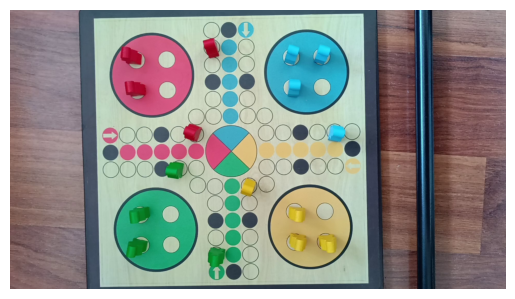

In [10]:
cap = cv2.VideoCapture(videopath)
if not cap.isOpened():
    raise Exception("Could not open")


frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

print(frame_width, frame_height)

fps = cap.get(cv2.CAP_PROP_FPS)
fps

_, frame = cap.read()
imshow(frame)

In [11]:
from enum import Enum

class Color(Enum):
    YELLOW = 1
    RED = 2
    GREEN = 3
    BLUE = 4


In [28]:
COLOR_RANGES = {
        Color.RED: [
            (np.array([0, 120, 70]), np.array([10, 255, 255])), 
            (np.array([170, 120, 70]), np.array([180, 255, 255]))
        ],
        Color.YELLOW: [
            (np.array([15, 50, 50]), np.array([35, 255, 255]))
        ],
        Color.GREEN: [
            (np.array([35, 50, 50]), np.array([85, 255, 255]))
        ],
        Color.BLUE: [
           (np.array([90, 50, 50]), np.array([130, 255, 255])) 
        ],
    }

def detect_dominant_color(image_fragment) -> Color:
    hsv = cv2.cvtColor(image_fragment, cv2.COLOR_BGR2HSV)
    
    
    color_counts = {color: 0 for color in COLOR_RANGES.keys()}
    for color, ranges in COLOR_RANGES.items():
        for lower, upper in ranges:
            mask = cv2.inRange(hsv, lower, upper)
            color_counts[color] += cv2.countNonZero(mask)
    dominant_color = max(color_counts, key=color_counts.get)
    
    return dominant_color


In [33]:
cv2.GaussianBlur?

Docstring:
GaussianBlur(src, ksize, sigmaX[, dst[, sigmaY[, borderType]]]) -> dst
.   @brief Blurs an image using a Gaussian filter.
.   
.   The function convolves the source image with the specified Gaussian kernel. In-place filtering is
.   supported.
.   
.   @param src input image; the image can have any number of channels, which are processed
.   independently, but the depth should be CV_8U, CV_16U, CV_16S, CV_32F or CV_64F.
.   @param dst output image of the same size and type as src.
.   @param ksize Gaussian kernel size. ksize.width and ksize.height can differ but they both must be
.   positive and odd. Or, they can be zero's and then they are computed from sigma.
.   @param sigmaX Gaussian kernel standard deviation in X direction.
.   @param sigmaY Gaussian kernel standard deviation in Y direction; if sigmaY is zero, it is set to be
.   equal to sigmaX, if both sigmas are zeros, they are computed from ksize.width and ksize.height,
.   respectively (see #getGaussianKernel for 

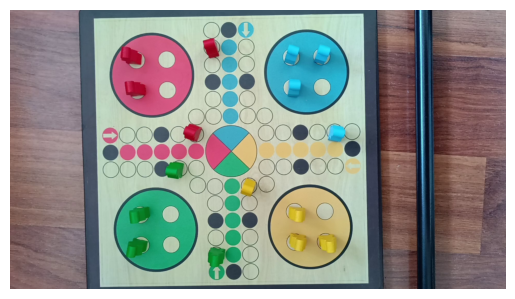

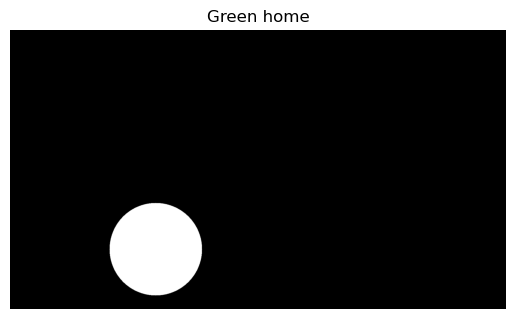

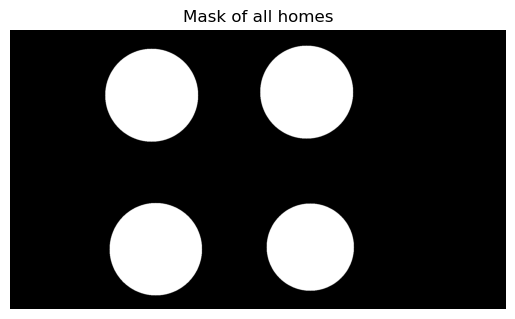

In [135]:
def get_home_masks(frame_gray):
    assert len(frame.shape) == 3, "frame must be BGR"   
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_gray = cv2.medianBlur(frame_gray, 5)
    circles = cv2.HoughCircles(
        frame_gray,
        method = cv2.HOUGH_GRADIENT,
        dp = 1,
        minDist = int(min(frame_height, frame_width) * 0.4),
        param1 = 50,
        param2 = 30,
        minRadius=int(min(frame_height, frame_width) * 0.125),
        maxRadius=int(min(frame_height, frame_width) * 0.25),
    )

    homes = {
                 Color.RED: dict(center = None, radius = None, mask=None),      
                 Color.BLUE: dict(center = None, radius = None, mask=None),
                 Color.GREEN:  dict(center = None, radius = None, mask=None),
                 Color.YELLOW: dict(center = None, radius = None, mask=None),
        }
                 
        
    circles = np.uint16(np.around(circles))
    for ((x,y,r), color) in zip(circles[0,:], homes):
        
        mask =   np.zeros(frame_gray.shape + (3,), dtype=np.uint8)
        cv2.circle(mask ,(x,y),int(1.1*r),(255,255,255),-1)
        color = detect_dominant_color(frame & mask)
        homes[color]["center"] = (x,y)
        homes[color]["radius"] = r
        homes[color]["mask"] = mask

    return homes

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
homes = get_home_masks(frame)

imshow(frame)
imshow(homes[Color.GREEN]["mask"], title="Green home")
all_homes_mask = homes[Color.GREEN]["mask"] | homes [Color.RED]["mask"] | homes[Color.YELLOW]["mask"] | homes[Color.BLUE]["mask"]
imshow(all_homes_mask, title="Mask of all homes")

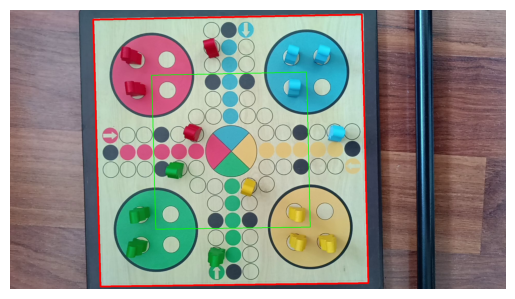

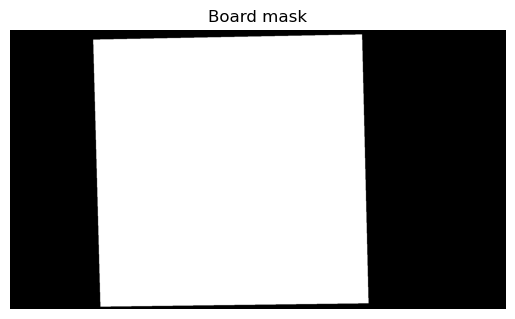

In [78]:
def get_board_mask_from_homes(frame, homes, verbose = False):
    
    corners = sorted([home["center"] for home in homes.values()], key = lambda x: x[1])
    top_points = corners[:2]
    bottom_points = corners[2:]
    
    top_left, top_right = sorted(top_points, key=lambda x: x[0])
    bottom_left, bottom_right = sorted(bottom_points, key=lambda x: x[0])

    contour = np.array([top_left, top_right, bottom_right, bottom_left],dtype=np.int32)
    M = cv2.moments(contour)
    if M['m00'] != 0:
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
    else:
        raise ValueError("Something wrong with home centers")

    home_dist_to_board_len_ratio = 26.0 / 15.0
    
    scaled_contour = []
    for point in contour:
        x, y = point
        # Scale the point relative to the centroid
        new_x = cx + home_dist_to_board_len_ratio * (x - cx)
        new_y = cy + home_dist_to_board_len_ratio * (y - cy)
        scaled_contour.append([[int(new_x), int(new_y)]])
        
    scaled_contour = np.array(scaled_contour, dtype=np.int32)
    # print(contour.shape)
    if verbose:
        output_image = frame.copy()
        cv2.drawContours(output_image, [contour], -1, (0,255,0),2)
        cv2.drawContours(output_image, [scaled_contour], -1, (0,0,255),5)
        imshow(output_image)

    board_mask = np.zeros_like(frame)
    cv2.drawContours(board_mask, [scaled_contour], -1, (255,255,255),-1)
    return board_mask

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
board_mask = get_board_mask_from_homes(frame, homes, verbose=True)
# if board_mask == None:
#     board_mask = np.ones_like(frame, dtype=np.uint8) * 255
# homes
imshow(board_mask, "Board mask")


dict_keys(['center', <Color.RED: 2>, <Color.BLUE: 4>, <Color.GREEN: 3>, <Color.YELLOW: 1>])


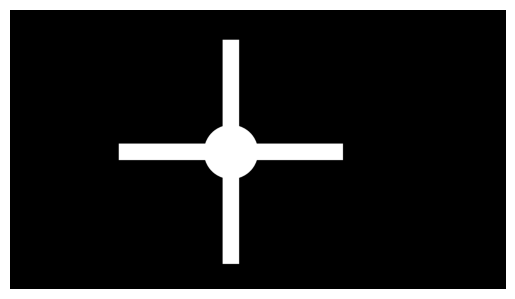

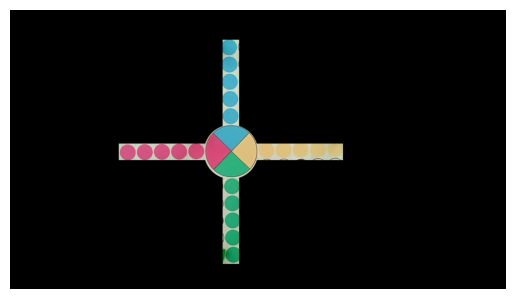

In [113]:
def get_target_bases(frame):
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(
            frame_gray,
            method = cv2.HOUGH_GRADIENT,
            dp = 2,
            minDist = int(min(frame_height, frame_width)),
            param1 = 100,
            param2=100,
            minRadius=int(min(frame_height, frame_width) * 0.055),
            maxRadius=int(min(frame_height, frame_width) * 0.1),
        )
    circles = np.uint16(np.around(circles))
    assert len(circles) == 1
    (x,y,r) = circles[0][0]
    targets = dict()
    

    center_circle_mask = np.zeros_like(frame)  
    cv2.circle(center_circle_mask ,(x,y),int(r*1.05),(255,255,255),-1)
    targets["center"] = center_circle_mask
    
    target_base_thickness = int(min(frame_height, frame_width) * 0.06)
    target_base_length = int(min(frame_height, frame_width) * 0.31)
    
    left_target_x = x-r-target_base_length
    left_target_y = y-target_base_thickness//2
    
    up_target_x = x - target_base_thickness//2
    up_target_y = y - r - target_base_length
    
    down_target_x = x - target_base_thickness//2
    down_target_y = y + r
    
    right_target_x = x + r
    right_target_y = y - target_base_thickness//2
    
    
    empty_mask = np.zeros_like(frame)  
    left_target_mask = cv2.rectangle(empty_mask, (left_target_x, left_target_y, target_base_length, target_base_thickness), (255,255,255), -1)
    color = detect_dominant_color(frame & left_target_mask)
    targets[color] = left_target_mask
    
    empty_mask = np.zeros_like(frame)
    up_target_mask = cv2.rectangle(empty_mask, (up_target_x, up_target_y, target_base_thickness, target_base_length ), (255,255,255), -1)
    color = detect_dominant_color(frame & up_target_mask)
    targets[color] = up_target_mask
    
    empty_mask = np.zeros_like(frame)
    down_target_mask = cv2.rectangle(empty_mask, (down_target_x, down_target_y, target_base_thickness, target_base_length), (255,255,255), -1)
    color = detect_dominant_color(frame & down_target_mask)
    targets[color] = down_target_mask
    
    empty_mask = np.zeros_like(frame)   
    right_target_mask = cv2.rectangle(empty_mask, (right_target_x, right_target_y, target_base_length, target_base_thickness), (255,255,255), -1)
    color = detect_dominant_color(frame & right_target_mask)
    targets[color] = right_target_mask

    
    return targets

cap.set(cv2.CAP_PROP_POS_FRAMES,20)
ret, frame = cap.read()

frame_eq = np.zeros_like(frame)
frame_eq[:,:,0] = cv2.equalizeHist(frame[:,:,0])
frame_eq[:,:,1] = cv2.equalizeHist(frame[:,:,1])
frame_eq[:,:,2] = cv2.equalizeHist(frame[:,:,2])

targets = get_target_bases(frame_eq & board_mask)
print(targets.keys())
all_target_bases_mask = targets["center"] | targets[Color.GREEN] | targets[Color.RED]| targets[Color.YELLOW]| targets[Color.BLUE]
imshow(all_target_bases_mask)
imshow(frame & all_target_bases_mask)


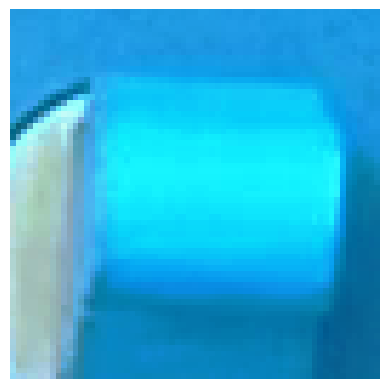

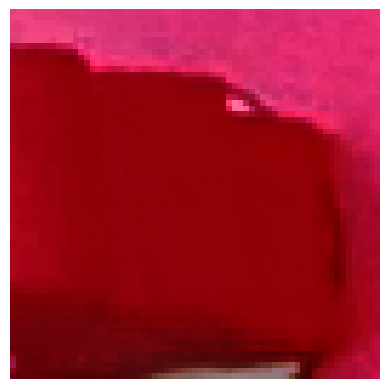

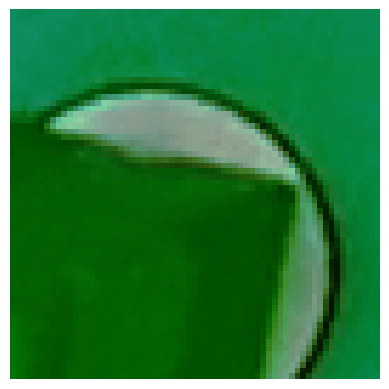

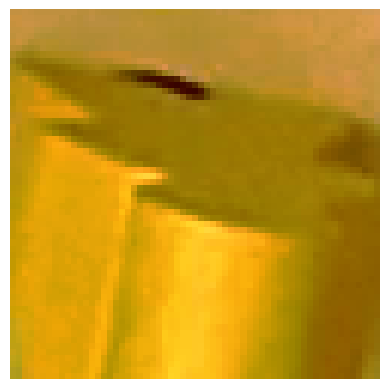

In [114]:
def get_pawn_image(frame, home: dict):
    my_home_center = home["center"]
    my_home_radius = home["radius"]
    
    x, y = my_home_center
    w, h = int(0.4*my_home_radius), int(0.4*my_home_radius) 
    x -= int(0.1 * my_home_radius)
    y += int(0.1 * my_home_radius)
    
    # pawn = frame(x,y) , (x - w,y + h)
    pawn = frame[y: y+h, x-w : x]
    return pawn

cap.set(cv2.CAP_PROP_POS_FRAMES,53)
ret, frame = cap.read()
frame_eq = np.zeros_like(frame)
frame_eq[:,:,0] = cv2.equalizeHist(frame[:,:,0])
frame_eq[:,:,1] = cv2.equalizeHist(frame[:,:,1])
frame_eq[:,:,2] = cv2.equalizeHist(frame[:,:,2])

blue_pawn = get_pawn_image(frame_eq, homes[Color.BLUE])
red_pawn = get_pawn_image(frame_eq, homes[Color.RED])
green_pawn = get_pawn_image(frame_eq, homes[Color.GREEN])
yellow_pawn = get_pawn_image(frame_eq, homes[Color.YELLOW])
imshow(blue_pawn)
imshow(red_pawn)
imshow(green_pawn)
imshow(yellow_pawn)

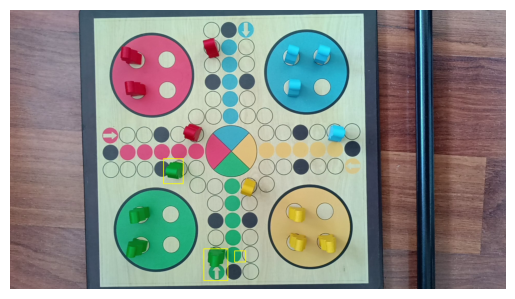

In [122]:
def get_pawn_boxes(sidewalk, target):
    sidewalk_hsv = cv2.cvtColor(sidewalk, cv2.COLOR_BGR2HSV)
    target = cv2.cvtColor(target, cv2.COLOR_BGR2HSV)
    target_hs_histogram = cv2.calcHist([target],[0,1], None, [180,256], [0,180,0,256])
    cv2.normalize(target_hs_histogram, target_hs_histogram,0,255,cv2.NORM_MINMAX)
    B = cv2.calcBackProject([sidewalk_hsv], [0,1], target_hs_histogram, [0,180,0,256],1)
    # B = cv2.morphologyEx(B, cv2.MORPH_ERODE, np.ones((3,3)))
    # imshow(B)
    B = cv2.morphologyEx(B, cv2.MORPH_ERODE, np.ones((3,3)))
    
    B = cv2.morphologyEx(B, cv2.MORPH_DILATE, np.ones((29,29)), iterations=2)
    B = cv2.morphologyEx(B, cv2.MORPH_ERODE, np.ones((15,15)))
    # imshow(B)
    
    B = B > 10
    # imshow(B)
    contours, _ = cv2.findContours(B.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    pawn_boxes = []
    min_pawn_area = (min(frame_width, frame_height) * 0.02)**2
    max_pawn_area = (min(frame_width, frame_height) * 0.10)**2
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_pawn_area < area < max_pawn_area:
            pawn_boxes.append(cv2.boundingRect(contour))
            
    if len(pawn_boxes) > 4:
        #raise DetectionError(f"Detected {len(pawn_boxes)} pawns")
        ...
        
    return pawn_boxes


cap.set(cv2.CAP_PROP_POS_FRAMES,3)
ret, frame = cap.read()

frame_eq = np.zeros_like(frame)
frame_eq[:,:,0] = cv2.equalizeHist(frame[:,:,0])
frame_eq[:,:,1] = cv2.equalizeHist(frame[:,:,1])
frame_eq[:,:,2] = cv2.equalizeHist(frame[:,:,2])
# imshow(frame_eq)
board = frame_eq & board_mask
sidewalk = board & ~all_homes_mask & ~all_target_bases_mask
# imshow(board & sidewalk)

target = green_pawn
pawn_boxes = get_pawn_boxes(sidewalk, target)
for (x,y,w,h) in pawn_boxes:
    cv2.rectangle(frame, (x, y), (x+w, y+h), YELLOW_BGR, 2)
imshow(frame)

In [137]:
def render_video(in_path, out_path, seconds=None):
    cap = cv2.VideoCapture(in_path)
    if not cap.isOpened():
        raise Exception(f"Could not open {in_path}")
        
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    fps = cap.get(cv2.CAP_PROP_FPS)

    video_out = cv2.VideoWriter(
        out_path,
        cv2.VideoWriter_fourcc(*"DIVX"),
        fps,
        (frame_width, frame_height),
    )
    processed_frames = 0
    frames_to_generate = np.inf if seconds is None else seconds * fps
    
    cap.set(cv2.CAP_PROP_POS_FRAMES,0)
    while cap.isOpened():
        ret, frame = cap.read()
        if frame is None:
            print(ret)
            break
        frame_eq = np.zeros_like(frame)
        frame_eq[:,:,0] = cv2.equalizeHist(frame[:,:,0])
        frame_eq[:,:,1] = cv2.equalizeHist(frame[:,:,1])
        frame_eq[:,:,2] = cv2.equalizeHist(frame[:,:,2])
        board = board_mask & frame_eq
        sidewalk = board & ~all_homes_mask & ~all_target_bases_mask
        target = yellow_pawn
        pawn_boxes = get_pawn_boxes(sidewalk, target)
        for (x,y,w,h) in pawn_boxes:
            cv2.rectangle(frame, (x, y), (x+w, y+h), YELLOW_BGR, 2)
       
        target = red_pawn
        pawn_boxes = get_pawn_boxes(sidewalk, target)
        for (x,y,w,h) in pawn_boxes:
            cv2.rectangle(frame, (x, y), (x+w, y+h), RED_BGR, 2)
       
        target = green_pawn
        pawn_boxes = get_pawn_boxes(sidewalk, target)
        for (x,y,w,h) in pawn_boxes:
            cv2.rectangle(frame, (x, y), (x+w, y+h), GREEN_BGR, 3)
    
        
        # target = blue_pawn
        target = cv2.imread("fotos/blue_pawn.png")
        pawn_boxes = get_pawn_boxes(sidewalk, target)
        for (x,y,w,h) in pawn_boxes:
            cv2.rectangle(frame, (x, y), (x+w, y+h), BLUE_BGR, 2)
            
        video_out.write(frame)
        processed_frames += 1
        if processed_frames >= frames_to_generate:
            break
    cap.release()
    video_out.release()

# Result 

In [138]:
%%time
render_video("videos/easy/gameplay1.mp4", "outs/hist/gameplay1.avi")
render_video("videos/easy/gameplay2.mp4", "outs/hist/gameplay2.avi")
render_video("videos/easy/gameplay3.mp4", "outs/hist/gameplay3.avi")

False
False
False
CPU times: user 11min 3s, sys: 7min 47s, total: 18min 50s
Wall time: 5min 3s


In [125]:
!mpv output.avi > /dev/null